In [141]:
# imports
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from matplotlib.colors import LogNorm

In [142]:
class DataProcessor():
    def __init__(self, particle_one, particle_two, shuffle=True, train_prop=0.7, valid_prop=0.3, test_prop=0.1):
        super(DataProcessor,self).__init__()
        self.CLASS_ONE = particle_one
        self.CLASS_TWO = particle_two
        self.c1 = h5py.File('/fast_scratch_1/QVAE/data/calo/'+self.CLASS_ONE+'.hdf5', 'r')
        self.c2 = h5py.File('/fast_scratch_1/QVAE/data/calo/'+self.CLASS_TWO+'.hdf5', 'r') 
        self.gen_one = 'gen_'+particle_one
        self.gen_two = 'gen_'+particle_two
        self.shuffle = shuffle
        self.train_prop = train_prop
        self.valid_prop = valid_prop
        self.test_prop = test_prop
        self._BASE = '/home/s4hoque/DwaveSampInteg'
        # self.gen_piplus = self._BASE+'/CaloQVAE/outputs/2022-12-01/22-29-17/synthetic_images_piplus.pt'
        # self.gen_gamma = self._BASE+'/CaloQVAE/outputs/2022-11-30/18-02-26/synthetic_images_gamma.pt'
        # self.gen_eplus = self._BASE+'/CaloQVAE/outputs/2022-11-30/22-26-46/synthetic_images_eplus.pt'
        self.gen_piplus = self._BASE+'/CaloQVAE/notebooks/synthetic_images/synthetic_images_piplus.pt'
        self.gen_gamma = self._BASE+'/CaloQVAE/notebooks/synthetic_images/synthetic_images_gamma.pt'
        self.gen_eplus = self._BASE+'/CaloQVAE/notebooks/synthetic_images/synthetic_images_eplus.pt'
        self.gen_dict = {
            'gen_piplus': self.gen_piplus,
            'gen_gamma': self.gen_gamma,
            'gen_eplus': self.gen_eplus
        }
        
        
    def flattened_class_data(self, class_num):
        c_layer_0 = torch.tensor(np.array(class_num['layer_0']))
        c_layer_1 = torch.tensor(np.array(class_num['layer_1']))
        c_layer_2 = torch.tensor(np.array(class_num['layer_2']))
        c_flatten_0 = torch.flatten(c_layer_0, start_dim=1)
        c_flatten_1 = torch.flatten(c_layer_1, start_dim=1)
        c_flatten_2 = torch.flatten(c_layer_2, start_dim=1)
        flat_class_data = torch.cat((c_flatten_0,c_flatten_1,c_flatten_2), dim=1)
        return flat_class_data
    
    def get_synthetic_dataset(self):
        c1_dir = self.gen_dict[self.gen_one]
        c2_dir = self.gen_dict[self.gen_two]
        gen_c1_data = torch.load(c1_dir)
        gen_c2_data = torch.load(c2_dir)
        gen_c1_tensor = torch.cat(gen_c1_data) 
        gen_c2_tensor = torch.cat(gen_c2_data) 
        gen_c1_labels = torch.ones(gen_c1_tensor.size(0)) # ones
        gen_c2_labels = torch.zeros(gen_c2_tensor.size(0)) # zeros
        gen_dataset = torch.cat((gen_c1_tensor, gen_c2_tensor),dim=0)
        gen_targets = torch.cat((gen_c1_labels, gen_c2_labels), dim=0)
        # shuffle ...
        if self.shuffle==True:
            rand_perm = torch.randperm(gen_dataset.size(0))
            gen_dataset = gen_dataset[rand_perm].float()
            gen_targets = gen_targets[rand_perm]
        # may need to pass the synthetic inputs through a RELU
        return gen_dataset, gen_targets
          
    def get_geant_dataset(self):
        class_one_data = self.flattened_class_data(self.c1)
        class_two_data = self.flattened_class_data(self.c2)
        full_dataset = torch.cat((class_one_data, class_two_data), dim=0)
        # Getting labels
        c1_labels = torch.ones(class_one_data.size(0)) # ones
        c2_labels = torch.zeros(class_two_data.size(0)) # zeros
        targets = torch.cat((c1_labels, c2_labels), dim=0) # labels

        if self.shuffle==True:
            rand_perm = torch.randperm(full_dataset.size(0))
            full_dataset = full_dataset[rand_perm].float()
            targets = targets[rand_perm]
        return full_dataset, targets
    
    def train_test_split(self, geant = True):
        if geant==True: # split geant data
            full_dataset, targets = self.get_geant_dataset()
        else: # split synthetic data
            full_dataset, targets = self.get_synthetic_dataset()
        num_train_data = int(self.train_prop*full_dataset.size(0))
        train_data = full_dataset[:num_train_data]
        train_targets = targets[:num_train_data]
        valid_data = full_dataset[num_train_data:]
        valid_targets = targets[num_train_data:]
        return train_data, train_targets, valid_data, valid_targets

In [143]:
class Net(nn.Module):
    def __init__(self, num_features,  num_classes):
        super(Net, self).__init__() 
        self.fc1= nn.Linear(num_features, 512)
        self.nfc1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(p=0.2)
        
        self.fc2= nn.Linear(512, 1024)
        self.nfc2 = nn.BatchNorm1d(1024)
        self.drop2 = nn.Dropout(p=0.5)
        
        self.fc3= nn.Linear(1024, 2048)
        self.nfc3 = nn.BatchNorm1d(2048)
        self.drop3 = nn.Dropout(p=0.5)
        
        self.fc4= nn.Linear(2048, 1024)
        self.nfc4 = nn.BatchNorm1d(1024)
        self.drop4 = nn.Dropout(p=0.5)
        
        self.fc5= nn.Linear(1024, 128)
        self.nfc5 = nn.BatchNorm1d(128)
        self.drop5 = nn.Dropout(p=0.5)
        
        self.fc6= nn.Linear(128, num_classes)
        
    def forward(self, x):
        h1 = self.nfc1(self.drop1(func.leaky_relu(self.fc1(x)))) 
        h2 = self.nfc2(self.drop2(func.leaky_relu(self.fc2(h1))))
        h3 = self.nfc3(self.drop3(func.leaky_relu(self.fc3(h2))))
        h4 = self.nfc4(self.drop4(func.leaky_relu(self.fc4(h3))))
        h5 = self.drop5(func.leaky_relu(self.fc5(h4)))
        y = torch.sigmoid(self.fc6(h5))
        return y

In [144]:
"""
main function
"""
def fit(particle_one, particle_two, geant_train = True, num_epochs=40, display_epochs=2, lr=0.075):
    model = Net(num_features=504, num_classes=1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss = torch.nn.BCELoss(reduction= 'mean')
    obj_vals= []  
    train_accuracies = []
    valid_accuracies = []
    aux_accuracies = []
    dataloader =  DataProcessor(particle_one, particle_two)
    train_data, train_targets, valid_data, valid_targets = dataloader.train_test_split(geant=geant_train)
    print("Dimensions: train : {0}; target: {1}; valid: {2}; valid_target: {3}".format(train_data.size(), train_targets.size(), valid_data.size(), valid_targets.size()))
    if (geant_train==True):
        auxiliary_test_inputs, auxiliary_targets = dataloader.get_synthetic_dataset()
    else:
        auxiliary_test_inputs, auxiliary_targets = dataloader.get_geant_dataset()
    for epoch in range(num_epochs):   
        # train starts
        model.train()
        model_output = model.forward(train_data).reshape(-1)
        pred = (model_output>0.5).float()
        diff_tensor =  pred - train_targets 
        diff_tensor = torch.abs(diff_tensor)
        train_accuracy = 1-torch.sum(diff_tensor)/pred.size(0)
        train_accuracies.append(train_accuracy)
        model.eval()
        valid_output = model.forward(valid_data).reshape(-1)
        pred_valid = (valid_output>0.5).float()
        diff_tensor_valid =  pred_valid - valid_targets 
        diff_tensor_valid = torch.abs(diff_tensor_valid)
        valid_accuracy = 1-torch.sum(diff_tensor_valid)/pred_valid.size(0)
        valid_accuracies.append(valid_accuracy)
        # valid ends
        # begin auxiliary test
        model.eval() # precaution
        aux_output = model.forward(auxiliary_test_inputs).reshape(-1)
        pred_aux = (aux_output>0.5).float()
        diff_tensor_aux =  pred_aux - auxiliary_targets 
        diff_tensor_aux = torch.abs(diff_tensor_aux)
        aux_accuracy = 1-torch.sum(diff_tensor_aux)/pred_aux.size(0)
        aux_accuracies.append(aux_accuracy)   
        # end auxiliary test
        obj_val = loss(model_output, train_targets)
        optimizer.zero_grad() 
        obj_val.backward()
        optimizer.step() 
        obj_vals.append(obj_val.item())
        if (epoch+1) % display_epochs == 0:
            print ('Epoch [{}/{}]\tTrain Loss :{:.4f}\t train accuracy :{:.4f}%\t validation accuracy :{:.4f}%\t auxiliary class accuracy :{:.4f}%'.format(epoch+1, num_epochs, obj_val.item(), train_accuracy*100, valid_accuracy*100, aux_accuracy*100))
    print("\nTraining Completed")
    return obj_vals, train_accuracies, valid_accuracies, aux_accuracies, num_epochs, model

In [145]:
# Notes
# lr = 0.0004 is good for e+/gamma+ TRAIN using synthetic data
# MAYBE NEED TO INCREASE LEARNING RATE FOR GEANT_TRAINING with `gamma` & `eplus` particles probably try 0.01
# p+,e+ geant train (geant and synthetic test) -> 0.0005, 150 epochs more than enoughh

In [146]:
obj_vals, train_accuracies, valid_accuracies, aux_accuracies, num_epochs, model = fit(
    'piplus', 'eplus', 
    geant_train=True, 
    num_epochs=10,  
    display_epochs=1, 
    lr=0.0005)

Dimensions: train : torch.Size([14336, 504]); target: torch.Size([14336]); valid: torch.Size([6144, 504]); valid_target: torch.Size([6144])
Epoch [10/250]	Train Loss :0.0116	 train accuracy :99.7349%	 validation accuracy :99.6582%	 auxiliary class accuracy :97.8615%


KeyboardInterrupt: 

--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
    await self.process_one()
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
    await dispatch(*args)
TypeError: object NoneType can't be used in 'await' expression

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1089, in emit
    self.flush()
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1069, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.8/site-packages/ipykernel_launch

# Analysis

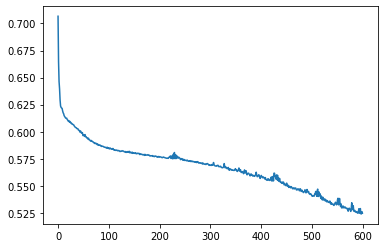

In [79]:
plt.plot(range(num_epochs), obj_vals) # plot loss function

Text(0.5, 1.0, 'GEANT Train (GEANT and Synthetic Test) ($\\gamma$ AND $e^{+}$)')

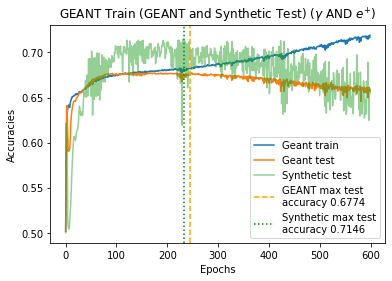

In [110]:
# plot accuracies
plt.plot(range(num_epochs), train_accuracies, label="Geant train")
plt.plot(range(num_epochs), valid_accuracies, label="Geant test")
plt.plot(range(num_epochs), aux_accuracies, label="Synthetic test", alpha=0.5)
max_valid_accuracy = max(valid_accuracies)
max_valid_index = valid_accuracies.index(max_valid_accuracy)+1
max_aux_accuracy = max(aux_accuracies)
max_aux_index = aux_accuracies.index(max_aux_accuracy)+1
plt.axvline(x=(max_valid_index), color='orange', linestyle='--', label="GEANT max test\naccuracy {:.4f}".format(max_valid_accuracy))
plt.axvline(x=(max_aux_index), color='green', linestyle=':', label="Synthetic max test\naccuracy {:.4f}".format(max_aux_accuracy))
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend(loc="lower right")
plt.title("GEANT Train (GEANT and Synthetic Test) ($\gamma$ AND $e^{+}$)")